# Laguage detection task
* Due 22.09.2017
* 4 points max

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### In this task objects will be words either in English or in French, and you will have to implement K-NN classifier predicting the language of each word by its Levenstein (edit) distance to the words in the training set.

* Download python wheel Python-Levenstein from <http://www.lfd.uci.edu/~gohlke/pythonlibs/#python-levenshtein>
* Install it with pip intall [wheel-name].
* Levenstein distance can now be computed as Levenshtein.distance(source, target)

In [2]:
import Levenshtein  
import sklearn as skl
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [14]:
with open('Data/en.txt') as f:
    english = f.readlines()
    
with open('Data/fr.txt') as f:
    french = f.readlines()

In [15]:
len(english), len(french)

(164144, 191448)

In [ ]:
english[:4]

In [ ]:
french[:4]

#### Forming train and test sets for your task.

In [3]:
def prepare_data(seed, train_size=15000, test_size=500):
    with open('Data/en.txt') as f:
        english = f.readlines()
    
    with open('Data/fr.txt') as f:
        french = f.readlines()
    
    random.seed(seed)
    random.shuffle(english)
    random.shuffle(french)
    N1 = train_size
    N2 = test_size
    X_train = english[:N1]+french[:N1]
    Y_train = [1]*N1 + [2]*N1
    X_test = english[N1:N1+N2]+french[N1:N1+N2]
    Y_test = [1]*N2 + [2]*N2
    
    inds = arange(len(X_train)) 
    inds = random.permutation(inds)
    X_train = np.array([X_train[ind] for ind in inds])
    Y_train = np.array([Y_train[ind] for ind in inds])

    inds = arange(len(X_test))
    inds = random.permutation(inds)
    X_test = np.array([X_test[ind] for ind in inds])
    Y_test = np.array([Y_test[ind] for ind in inds])
    
    return X_train, Y_train, X_test, Y_test

#### Implement KNN class having constructor, fit(X,Y), predict_one(x) and predict(X) methods.

* constructor should have parameter K
* predict_one(x) predicts class for single object
* predict(X) predicts class for each row of X

You will need this class, because default implementation of K-NN 
requires objects to be numeric vectors and your objects are strings.

In [25]:
class KNNForStrings:
    def __init__(self, number_of_neighbors=3):
        self.number_of_neighbors = number_of_neighbors
        self.metric_function = np.vectorize(Levenshtein.distance)
        self.word_distance_dict = {}

    def fit(self, X_np, Y_np):
        self.x_train = X_np
        self.y_train = Y_np

    def determen_clazz(self, inds_np, distances_np):
        neighbors_np = self.y_train[inds_np]
        unique_np, counts_np = np.unique(neighbors_np, return_counts=True)
        max_value_index = counts_np.argmax()
        clazz = unique_np[max_value_index]
        return clazz

    def predict(self, X_np):
        result = np.arange(X_np.shape[0])
        for word_index, word in enumerate(X_np):
            value = self.word_distance_dict.get(word, None)
            distances_np = None
            if value is None:
                distances_np = self.metric_function(self.x_train, word)
                self.word_distance_dict[word] = distances_np
            else:
                distances_np = value
            inds_np = np.argpartition(distances_np, self.number_of_neighbors)[0: self.number_of_neighbors]
            result[word_index] = self.determen_clazz(inds_np, distances_np)
        return result

    def predict_one(self, string):
        return self.predict(np.array([string]))

    def score(self, X, y, sample_weight=None):
        from sklearn.metrics import accuracy_score
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)

    def get_params(self, deep=True):
        return {"number_of_neighbors": self.number_of_neighbors}

    def set_params(self, **params):
        self.number_of_neighbors = params["number_of_neighbors"]
        return self


class KNNForStringsWithWeight(KNNForStrings):
    def determen_clazz(self, inds_np, distances_np):
        neighbors_label_np = self.y_train[inds_np]
        neighbors_distance_np = distances_np[inds_np]
        # Расчитаем веса
        neighbors_distance_weight_np = np.zeros(neighbors_distance_np.shape)
        for ind, el in enumerate(neighbors_distance_np):
            if el > 0:
                neighbors_distance_weight_np[ind] = 1 / el
            else:
                neighbors_distance_weight_np[ind] = self.number_of_neighbors
        # Найдём наибольший вес
        label_weight = dict()
        for ind, lable in enumerate(neighbors_label_np):
            weight = neighbors_distance_weight_np[ind]
            value = label_weight.get(lable, None)
            if value is None:
                label_weight[lable] = weight
            else:
                label_weight[lable] = weight + value
        max_label = 0
        max_weight = -1
        for k, v in label_weight.items():
            if v > max_weight:
                max_weight = v
                max_label = k

        return max_label

In [29]:
def do_experiment(X_train, Y_train, X_test, Y_test, knn, show_plot=True, knn_param_list = [1,3,5,7,11,21]):
    knn.fit(X_train, Y_train)    
    score_list = []
    for number in knn_param_list:
        knn.set_params(number_of_neighbors=number)    
        score_list.append(knn.score(X_test, Y_test))
    
    if show_plot:
        plt.plot(knn_param_list, score_list)
        plt.xlabel("Number of neighbors")
        plt.ylabel("Accuracy")
        plt.title("Accuracy test for " + knn.__class__.__name__)
        plt.xticks(knn_param_list)
        plt.show()
    return score_list

#### For K=[1,3,5,7,11,21] estimate accuracy of your KNN and plot the dependency between K and accuracy.

Посчитаем точность для разных выборок и найдём средее значение точности для каждого количества соседей

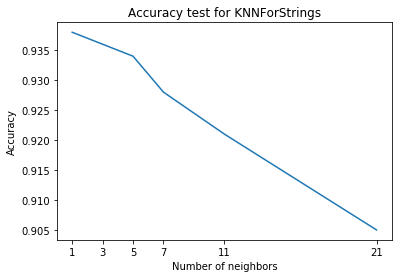

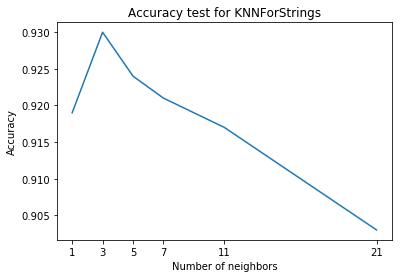

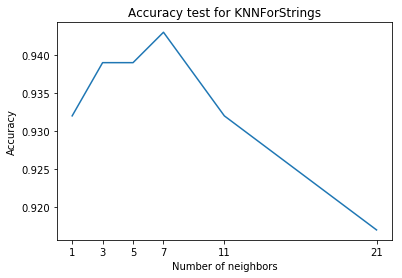

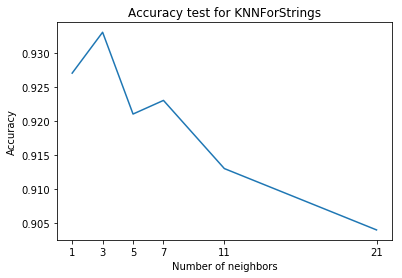

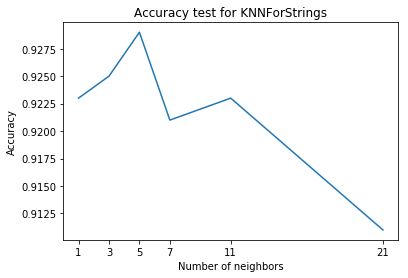

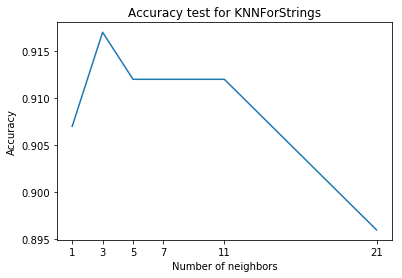

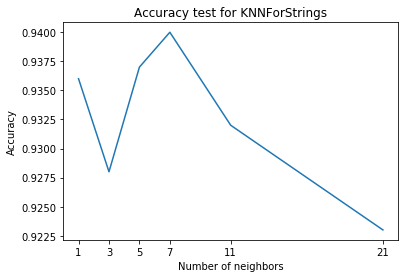

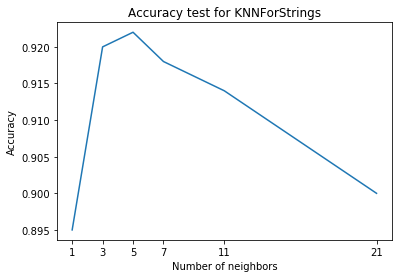

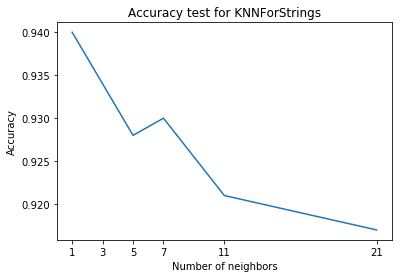

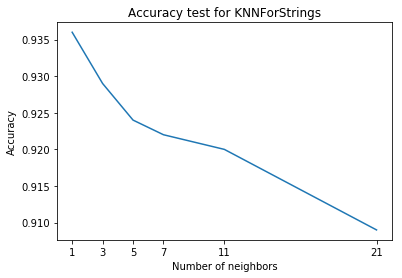

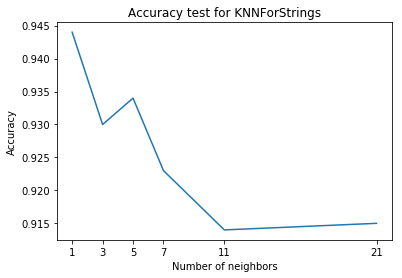

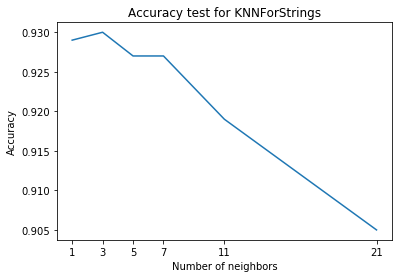

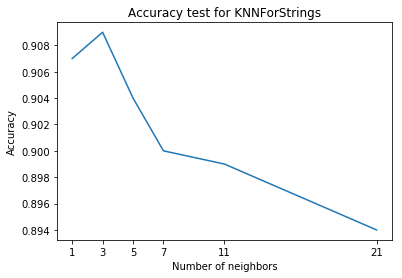

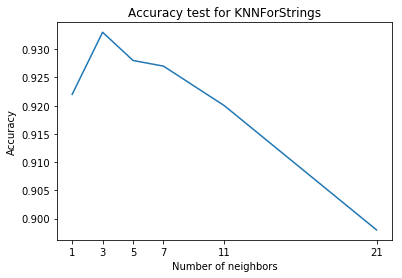

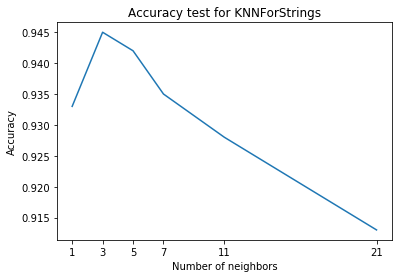

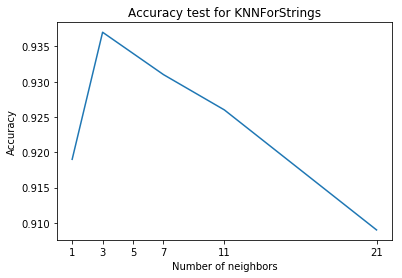

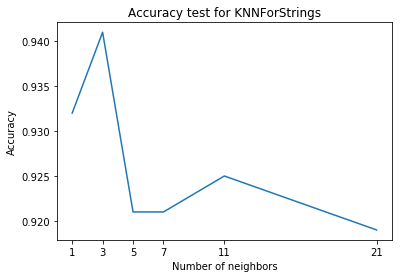

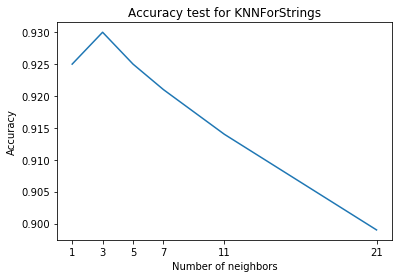

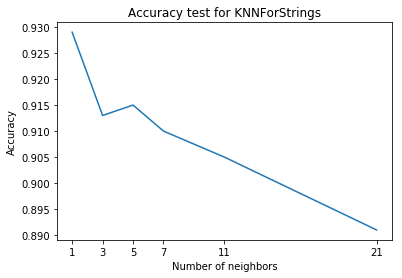

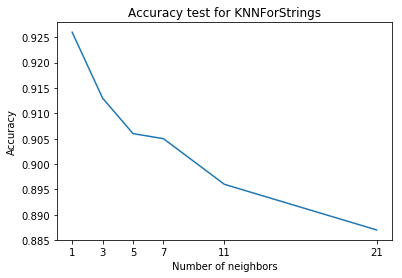

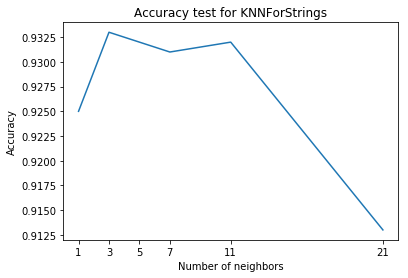

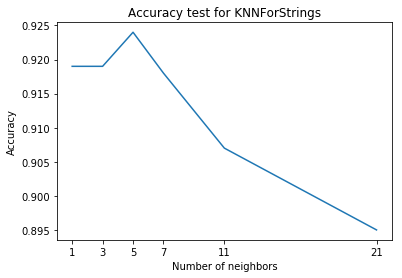

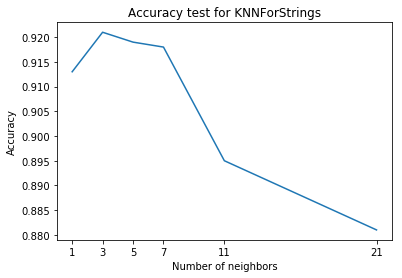

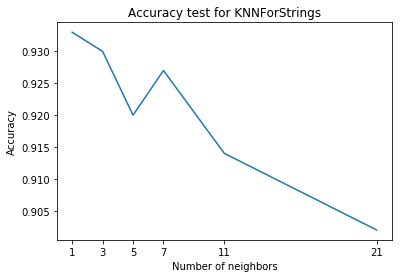

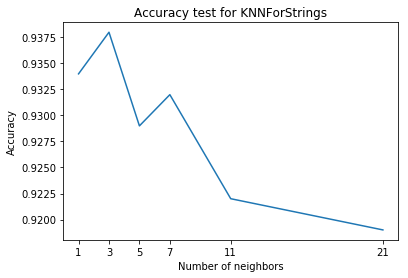

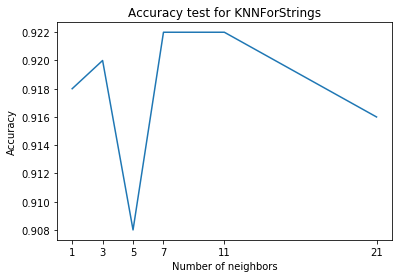

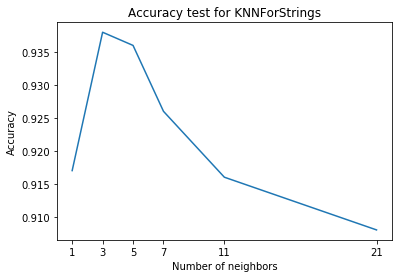

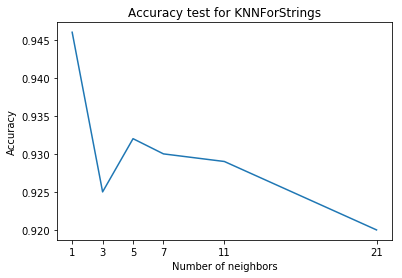

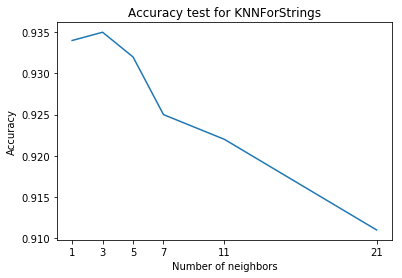

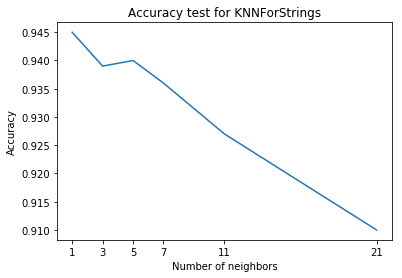

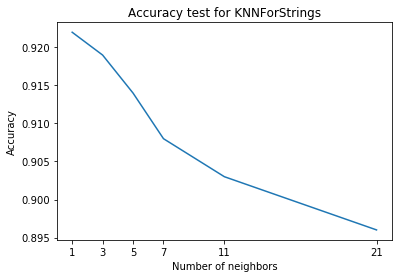

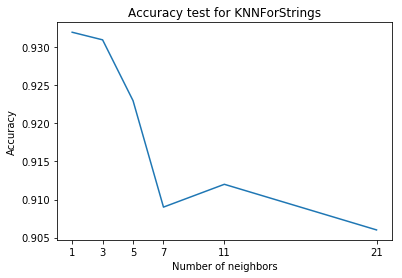

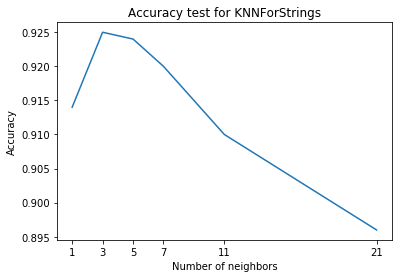

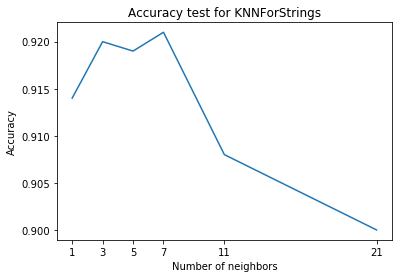

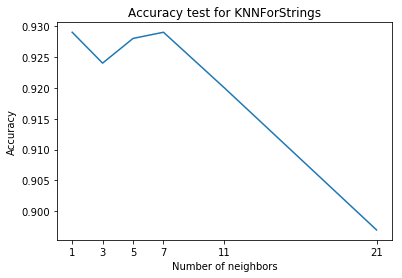

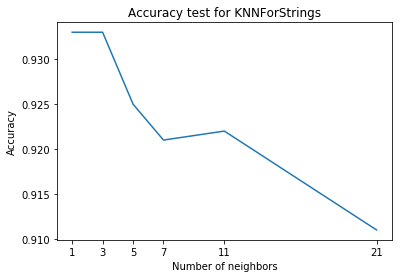

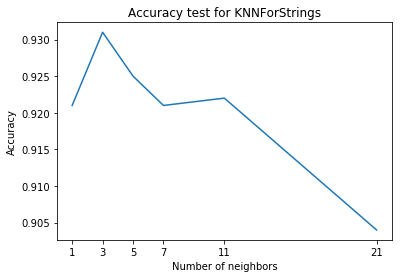

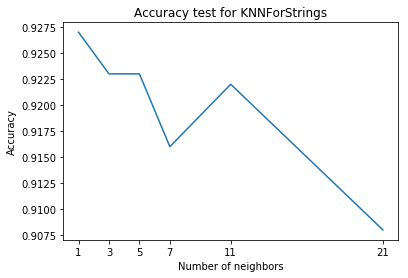

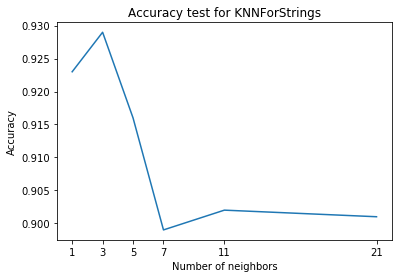

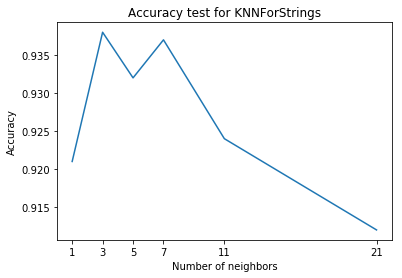

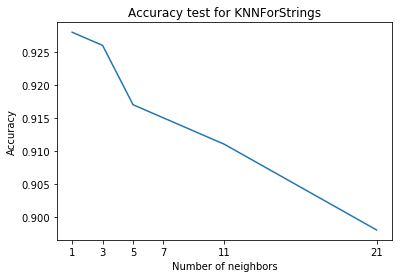

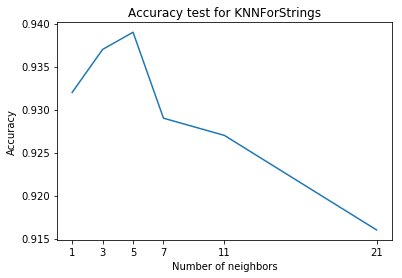

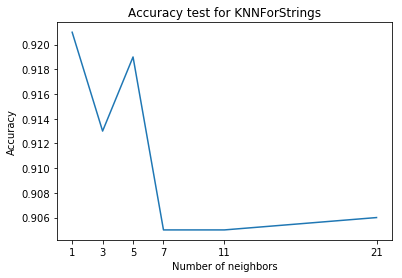

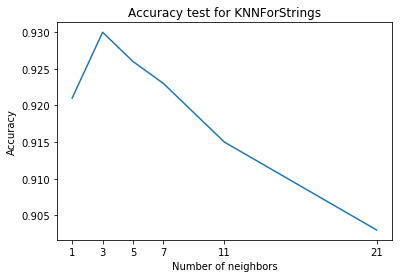

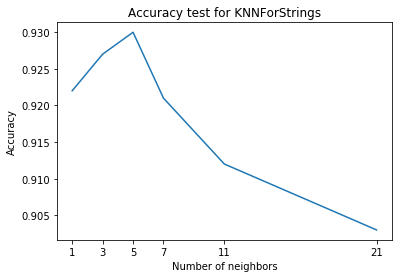

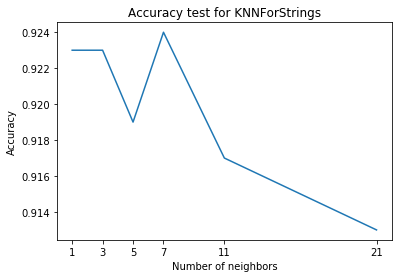

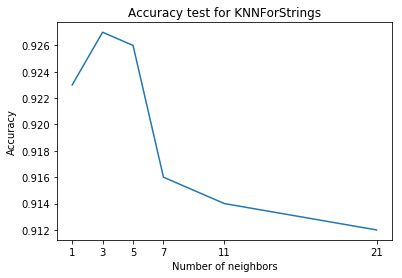

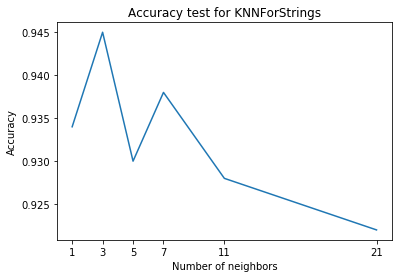

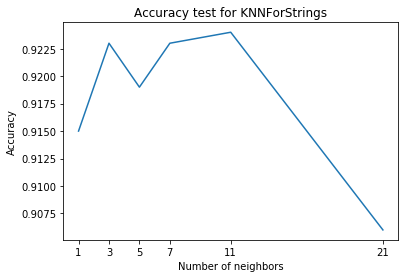

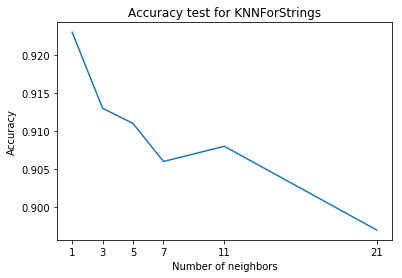

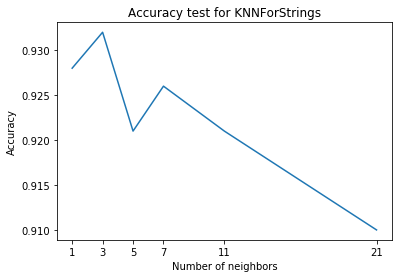

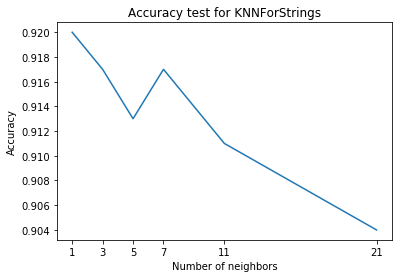

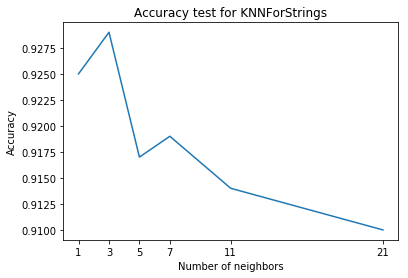

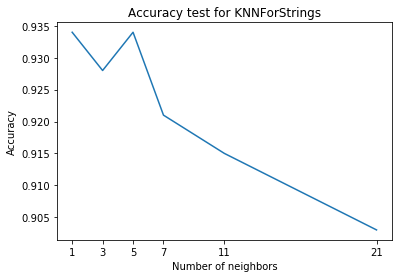

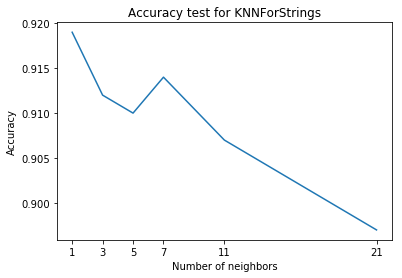

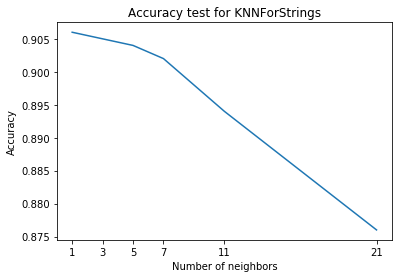

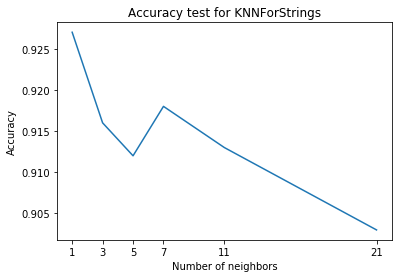

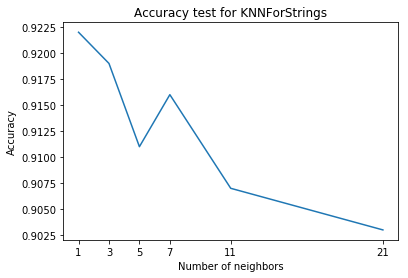

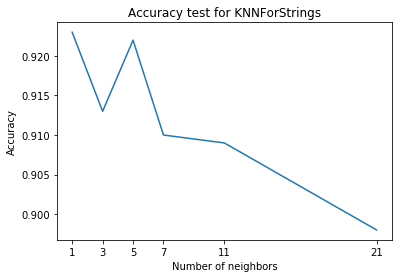

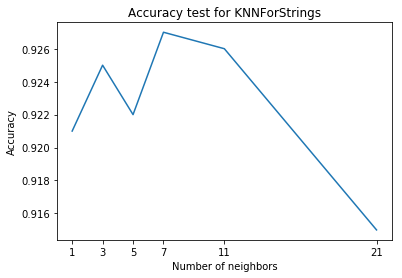

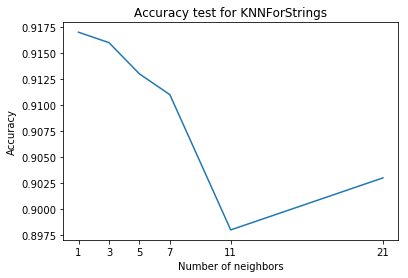

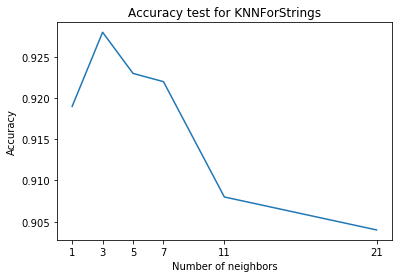

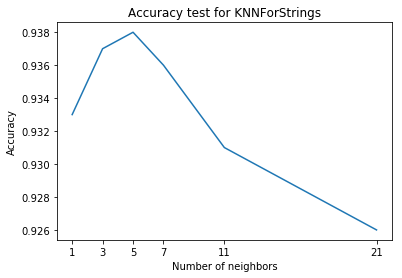

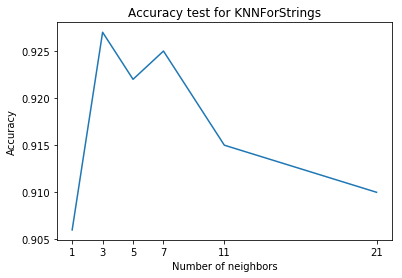

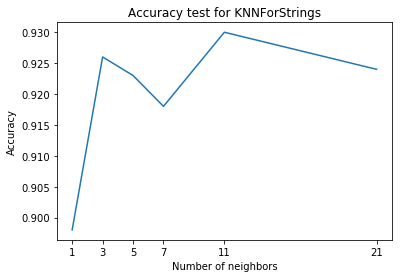

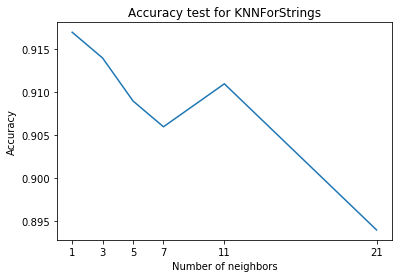

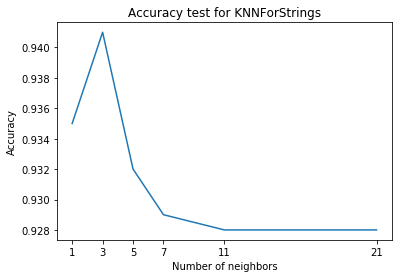

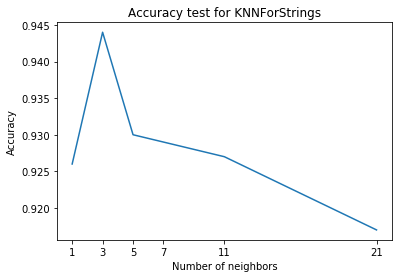

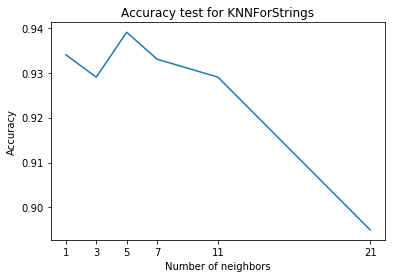

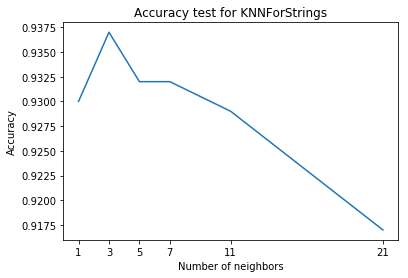

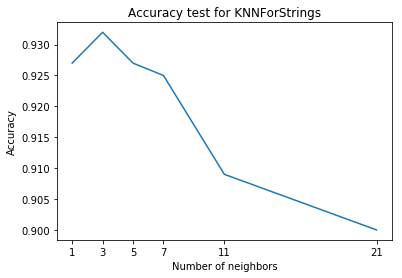

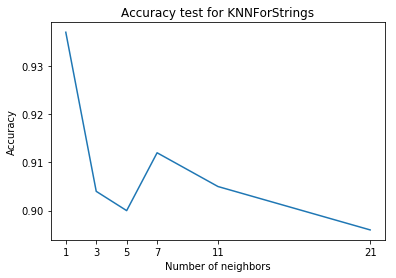

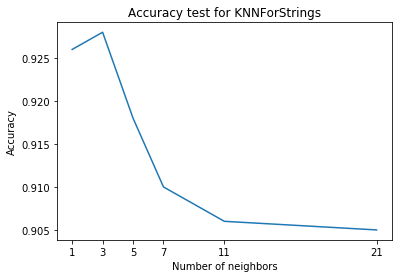

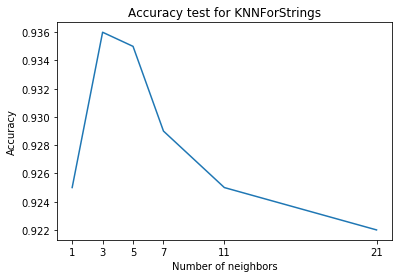

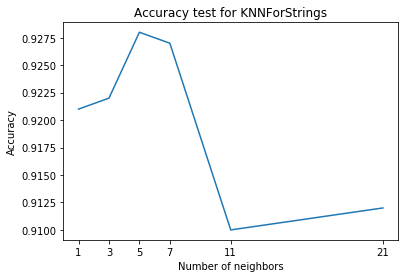

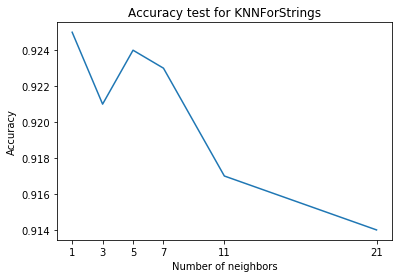

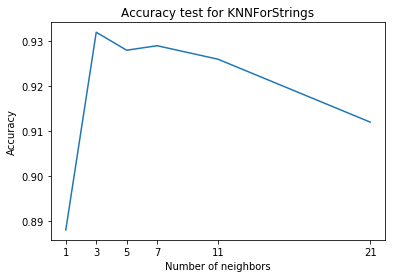

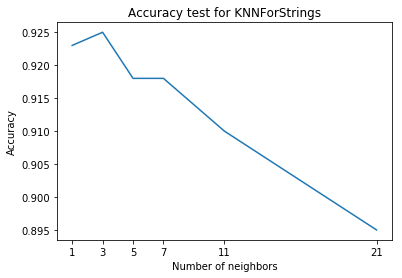

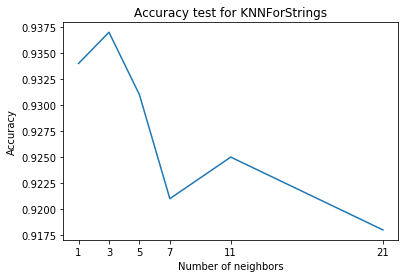

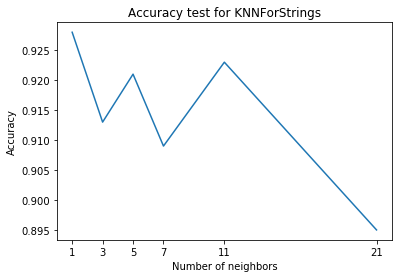

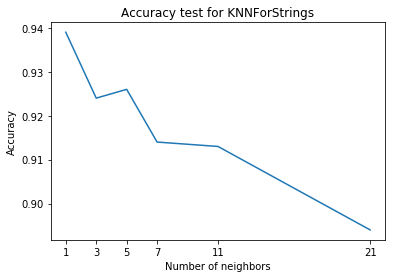

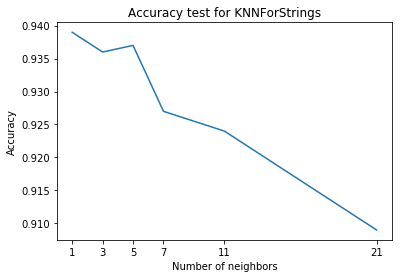

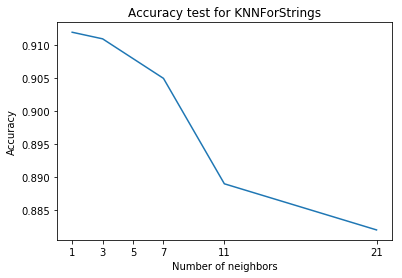

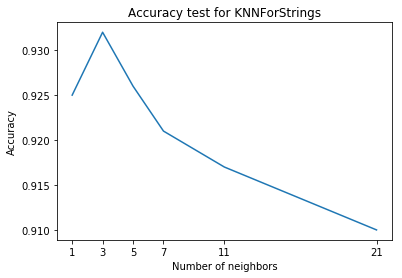

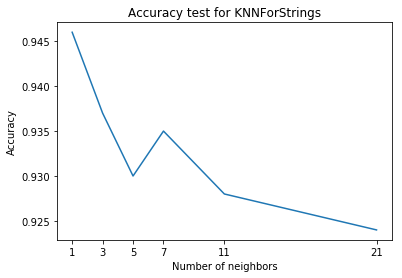

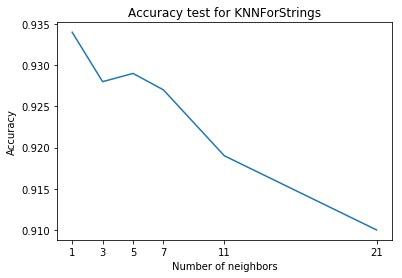

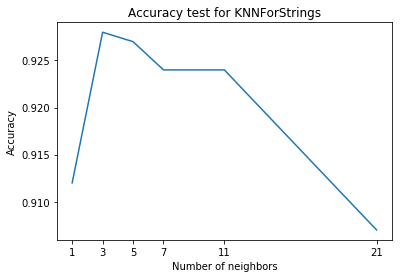

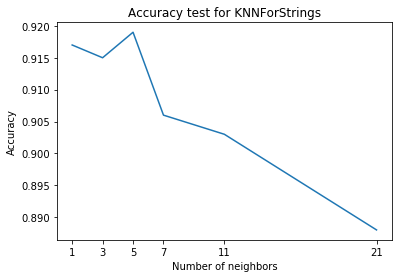

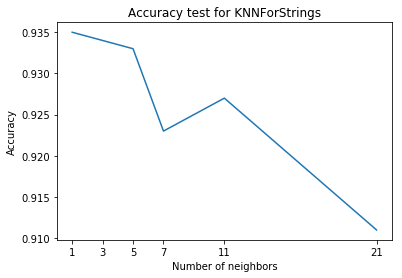

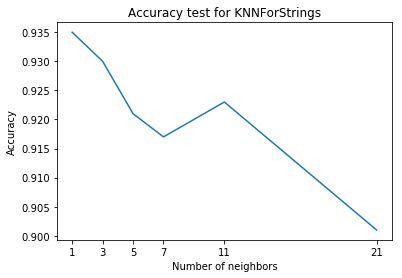

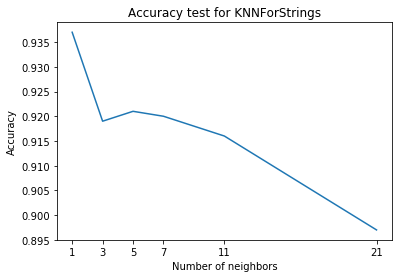

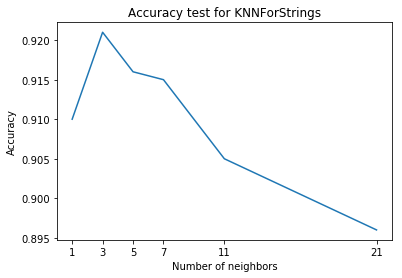

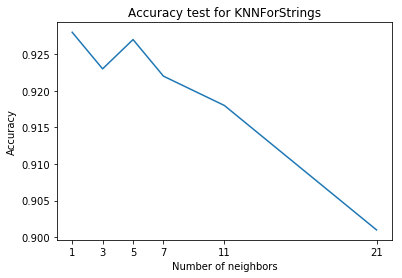

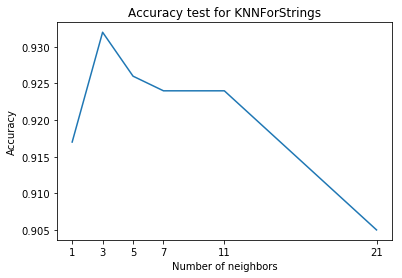

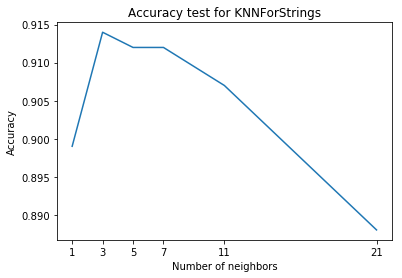

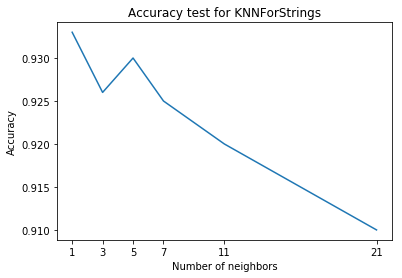

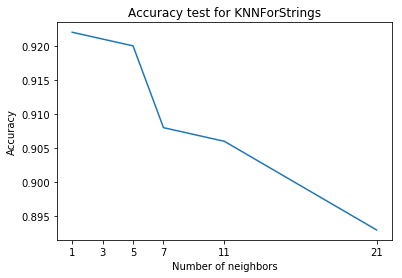

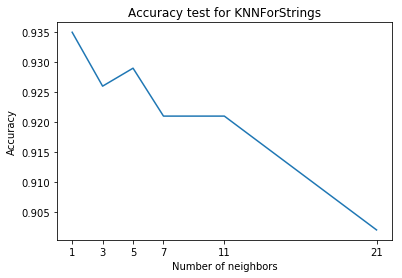

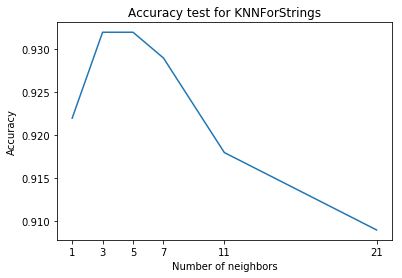

In [6]:
results = []
for i in range(100, 10000, 100):
    X_train, Y_train, X_test, Y_test = prepare_data(i)
    temp = do_experiment(X_train, Y_train, X_test, Y_test, KNNForStrings())
    results.append(temp)

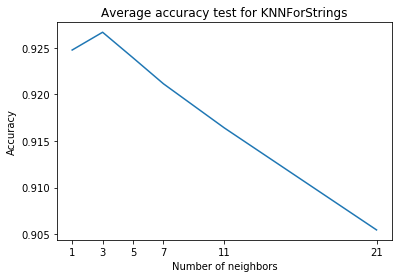

[ 0.92476768  0.92667677  0.92392929  0.92114141  0.91640404  0.90545455]


In [24]:
result_matrix = np.array(results)
average_result = result_matrix.mean(axis=0)
knn_param_list = [1,3,5,7,11,21]
plt.plot(knn_param_list, average_result)
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.title("Average accuracy test for KNNForStrings")
plt.xticks(knn_param_list)
plt.show()
print(average_result)

#### What value of K is optimal? Explain

Вывод: Проведя 100 экспериментов на различных выборках, KNN с числом соседей = 3 показал наилучшую точность - 92,6%.
С увеличением растояния Левенштейна, количество возможных вариантов перехода из одного слова в другое увеличивается. Следовательно увеличивается вероятность перейти слову из одного языка в слово другого языка. Таким образом, чем больше соседей мы рассматриваем, тем выше вероятность вовлечь в прияние решения слово из другого языка, что влечёт ошибки в предсказательной модели, что мы можем наблюдать при числе соседей > 3.
Отдельно стоит обратить внимание на модель с числом соседей = 1 и точностью 92,4%. Как видно из исследований, модель показывает хороший результат, но есть случае, когда одного соседа недостаточно для того, чтобы принятия правильного решения, например для англиского местоимение it и французкого il, где расстояние Левенштейна = 1.

#### Free hunt for bonus points: make whatever additional experiments you like to explore the data or improve the quality and report interesting findings.

Попробуем улучшить результат, добавив веса к растояниям. Проведём повторно экспиримент, используя KNN с весами.

In [26]:
results_KNNForStringsWithWeight = []
for i in range(100, 10000, 100):
    X_train, Y_train, X_test, Y_test = prepare_data(i)
    temp = do_experiment(X_train, Y_train, X_test, Y_test, KNNForStringsWithWeight(), show_plot=False)
    results_KNNForStringsWithWeight.append(temp)

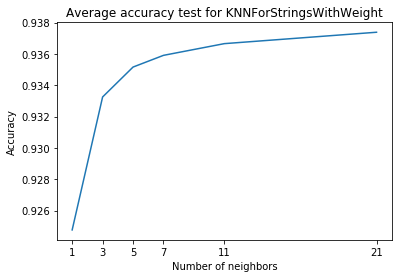

[ 0.92476768  0.93325253  0.93516162  0.93590909  0.93665657  0.93738384]


In [27]:
result_matrix = np.array(results_KNNForStringsWithWeight)
average_result = result_matrix.mean(axis=0)
knn_param_list = [1,3,5,7,11,21]
plt.plot(knn_param_list, average_result)
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.title("Average accuracy test for KNNForStringsWithWeight")
plt.xticks(knn_param_list)
plt.show()
print(average_result)

Проведя 100 экспериментов на различных выборках, KNN с весами и числом соседей = 21 показал наилучшую точность - 93,7%. Это связано с тем, что теперь из выборки K соседей мы отдаём предпочтения при принятии решения образцам с меньшим расстоянием Левенштейна.